<img align="left" src="https://www.taborelec.com/Pictures/logo.png">

### Qbit Pi Rotation 

Generator configuration 

Set SCLK – 8666MSas 

Define segment 2 length – 448 points 

Download waveform (Pi Pulse) – 4 point per cycle Sine wave with a Gaussian shape envelope. 

Create a task table of 1 lines: 

Task 1 		Enable Signal = 	CPU 

DTrigger  = 	ON 

Next Task 1 = 	end 

Download Task Table 

Enable Task Mode 

 

Digitizer Configuration 

Set SCLK – 2700MHz 

Set DDC mode to complex 

Set center frequency of channel 1 to 200MHz 

Define Frame configuration –	Number of frames = 1 

Frame size = 144 points 

Set Trigger Source to TASK1 

Set Trigger AWG delay  

Set capture frames to all 

 

 

DSP Configuration 

Select to store the IQ data 

Set IQ PATH Input to AMPH 

Set Decision frame size 50 points 

 

 

Create a loop that changes the amplitude of the output by 1mV, triggers the task table, polls the digitizer that the capture is done, erases the frame data and then repeats.  

In [1]:
import os
import sys
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

In [2]:
#matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt
from scipy import signal
import math

In [3]:
SCLK = 1e9

In [4]:
# Connect to instrument
admin = TepAdmin()
    
# Get list of available PXI slots
slot_ids = admin.get_slot_ids()

# Assume that at least one slot was found
sid = slot_ids[0]

 # Open a single-slot instrument:
inst = admin.open_instrument(slot_id=sid)

# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print('Connected to: ' + resp)

# Get the model name
resp = inst.send_scpi_query(":SYST:iNF:MODel?")
print("Model: " + resp)

# Infer the natural DAC waveform format
if 'P9082' in resp:
    dac_mode = 8
else:
    dac_mode = 16
print("DAC waveform format: {0} bits-per-point".format(dac_mode))


if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0



Connected to: Tabor Electronics,P9484M,000002210203,1.200.0
Model: P9484M
DAC waveform format: 16 bits-per-point


In [5]:
# Several initializations ..

inst.default_paranoia_level = 2

inst.send_scpi_cmd('*CLS; *RST')
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(SCLK))
inst.send_scpi_cmd(':INIT:CONT ON')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
inst.send_scpi_cmd(':TRAC:ZERO 1')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


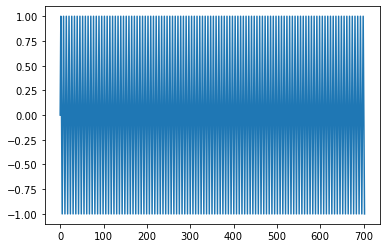

In [6]:
# Build a AWG segment that will be used as innput for the digitizer

# build sine wave
initDeg = 0
NUM_OF_CYCLES = 112
NUM_OF_SAMPLES = 4
SCLK = 8.666e9
NUM_OF_POINTS = NUM_OF_CYCLES * NUM_OF_SAMPLES 
SEG_LEN = NUM_OF_POINTS

#sine wave
x = np.linspace(initDeg, initDeg + 2*NUM_OF_CYCLES*math.pi-(2*math.pi)/NUM_OF_SAMPLES, NUM_OF_POINTS)
sinWave = (np.sin(x))

plt.plot(x, sinWave, '-')

7.466156512511298e-156


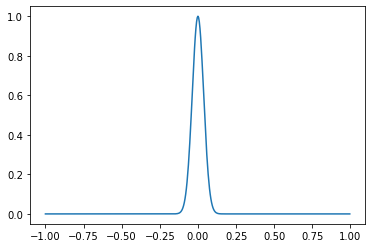

In [7]:
# gaussian wave form 
t = np.linspace(-1, 1, NUM_OF_POINTS, endpoint=False)
f = SCLK/NUM_OF_POINTS
#print('fc {0}'.format(f))
i, q, e = signal.gausspulse(t, fc=20, retquad=True, retenv=True)
gaussian = e
print(min(gaussian))
plt.plot(t, gaussian, '-')


before
<class 'numpy.uint16'>
[32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767 32767
 32767 32767 32767 32

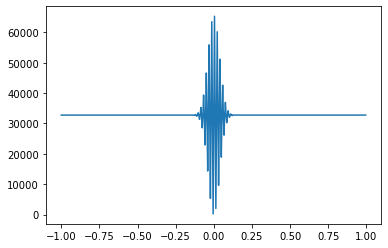

In [8]:

wave = [a*b for a,b in zip(sinWave,gaussian)]
# wave = np.round(wave)
#wave = np.clip(wave, 0, max_dac)
#print(type(wave[0]))

wave = (np.array(wave)  + 1.0) * half_dac
print('before'.format(wave))
wave = wave.astype(np.uint16)
print((type(wave[0])))
print(wave)
print(wave.size)
plt.plot(t, wave, '-')


# Creating Task Table 

In [9]:

# download it to segment 1 of channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEF 1,' + str(wave.size))
inst.send_scpi_cmd(':TRAC:SEL 1')

print('wave size: {0}'.format(wave.size))
# download the waveform to the selected segment
inst.write_binary_data(':TRAC:DATA', wave)

inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 1')
inst.send_scpi_cmd(':SOUR:VOLT 0.5')
inst.send_scpi_cmd(':OUTP ON')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

del sinWave, wave, e, i, q


wave size: 448
0, no error


In [10]:
tasklen = 1

#Select channel
cmd = ':INST:CHAN 1'
inst.send_scpi_cmd(cmd )

cmd = ':TASK:COMP:LENG {0}'.format(tasklen)
inst.send_scpi_cmd(cmd )



for i in range(tasklen):
    curr_task = i+1
    cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
    inst.send_scpi_cmd(cmd)
    cmd = ':TASK:COMP:DTRigger ON'        
    inst.send_scpi_cmd(cmd)
 
    if curr_task == 1:  
        cmd = ':TASK:COMP:ENAB CPU'
        
    if curr_task==tasklen:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
        inst.send_scpi_cmd(cmd)
    else:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
        inst.send_scpi_cmd(cmd )    

    cmd = ':TASK:COMP:TYPE SING'
    inst.send_scpi_cmd(cmd )

    cmd = ':TASK:COMP:LOOP {0}'.format(1)
    inst.send_scpi_cmd(cmd )

    cmd = ':TASK:COMP:SEGM {0}'.format(1)
    inst.send_scpi_cmd(cmd )

    
cmd = ':TASK:COMP:WRIT'
inst.send_scpi_cmd(cmd)
print('Downloading Task table to channel {0}'.format(1))

cmd = ':INST:CHAN {0}'.format(1)
inst.send_scpi_cmd(cmd)
    
cmd = ':OUTP ON'
inst.send_scpi_cmd(cmd)

cmd = 'FUNC:MODE TASK'
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error


## Setup Digitizer

In [11]:
# Setup the digitizer in two-channels mode
inst.send_scpi_cmd(':DIG:MODE DUAL')

# Set SCLK digitizer 
inst.send_scpi_cmd(':DIG:FREQ 2700MHz')

# Set DDC mode to complex
inst.send_scpi_cmd(':DIG:DDC:MODE COMPlex')

# Set center frequency of channel 1 to 200MHz
inst.send_scpi_cmd(':DIG:DDC:CFR1 200e6')

# Allocate 1000 frames of 864 samples
numframes, framelen = 1000, 864
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
capture_first, capture_count = 1, numframes
cmd = ":DIG:ACQuire:FRAM:CAPT {0},{1}".format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')

# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')

# Set Trigger AWG delay to 0
inst.send_scpi_cmd(':DIG:TRIG:DEL {0}'.format(1))

# Clean memory 
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("Set Digitizer: DUAL mode; ADC Trigger")


0, no error
Set Digitizer: DUAL mode; ADC Trigger


## Setup DSP

In [12]:
# Select to store the IQ data
inst.send_scpi_cmd(':DSP:STOR1 DSP1')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Set IQ PATH Input to AMPH
inst.send_scpi_cmd(':DSP:DEC:IQP:SEL 1')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
inst.send_scpi_cmd(':DSP:DEC:IQP:INP AMPH')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
# Set Decision frame size 50 points
inst.send_scpi_cmd(':DSP:DEC:FRAM {0}'.format(50))
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error
0, no error
0, no error
0, no error


## Acquire signals into Memory

In [13]:
# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')

# Start the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT ON')
print("Waiting to recive enter to generate trigger - press Enter to start trigger")
input()

inst.send_scpi_cmd('*TRG')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Waiting to recive enter to generate trigger - press Enter to start trigger

0, no error


## Read all frames from Memory

In [14]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("read data from DDR")


Total size in bytes: 1728000

0, no error
read data from DDR


## Plot Signals  - Need to fix, need to be x-y graph

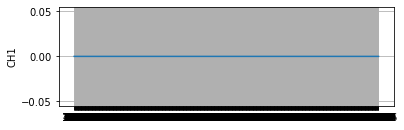

In [15]:
# Plot the samples
totlen = numframes * framelen
x = range(numframes * framelen)
plt.figure(1)
ax1 = plt.subplot(211)
ax1.set_xticks(np.arange(0, totlen, framelen))
ax1.grid(True)
ax1.plot(x, wav1)
ax1.set_ylabel('CH1')

plt.show()

In [ ]:
# close connection
inst.close_instrument()
admin.close_inst_admin()

In [ ]:

import numpy as np

a1 =  [1, 3, 1]
a2 = [3, 5, 2]

print([a*b for a,b in zip(a1,a2)])



In [ ]:
# Stam test
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 2 * 100, endpoint=False)
i, q, e = signal.gausspulse(t, fc=5, retquad=True, retenv=True)
plt.plot(t, i, t, q, t, e, '--')

In [ ]:
# Stam test
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 488, endpoint=False)
i, q, e = signal.gausspulse(t, fc=6.888e9, retquad=True, retenv=True)
plt.plot(t, i, t, q, t, e, '--')